In [1]:
import sys
sys.path.append('../')

## Oppsett av nevrale nettverk med PyTorch
Nevrale nettverk har tilsynelatende komplekse strukturer. Likevel består de av flere enkle og isolerte komponenter. Disse finner man i `torch.nn`. 

De fleste komponentene blir et _lag_ i nettverket, men det finnes komponenter som anvendes på eksisterende lag (feks aktiveringsfunksjoner). 

In [2]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

Den enkleste komponenten man finner i et nevrale nettverk er lineære lag. Matematisk gjør den en lineær transformasjon fra et vektorrom til et annet. Feks kan det lineære laget ta inn en vektor med 5 features, og outputte en vektor med 3 features:

<div >
<img src="../res/nn_5in_3out-cropped.svg" width="500px" height="auto" alt="SVG Image"/>
</div>

I PyTorch lager vi lineære lag gjennom `torch.nn.Linear`.

In [3]:
layer = nn.Linear(in_features=5, out_features=3) # Construct layer
layer

Linear(in_features=5, out_features=3, bias=True)

In [4]:
data = torch.Tensor([[1, 1, 1, 1, 1]])
print(f"Input vector: {data}")
output = layer(data) # Feed data into layer
print(f"Output vector: {output}")

Input vector: tensor([[1., 1., 1., 1., 1.]])
Output vector: tensor([[0.0952, 0.2752, 0.6093]], grad_fn=<AddmmBackward0>)


Hva er det egentlig som har skjedd her? Vektoren, som består av 5 enere, har blitt til transformert til en vektor med 3 tall. Vi studerer _vektene_ til det lineære laget.

In [5]:
print(layer.weight)
print(f"Weight shape: {layer.weight.shape}\n")

print(layer.bias)
print(f"Bias shape: {layer.bias.shape}")

Parameter containing:
tensor([[-0.2287,  0.1884,  0.0466, -0.0580,  0.1122],
        [ 0.4171, -0.2511,  0.1105, -0.4285,  0.4148],
        [ 0.3849,  0.1388,  0.3844,  0.1336, -0.1980]], requires_grad=True)
Weight shape: torch.Size([3, 5])

Parameter containing:
tensor([ 0.0347,  0.0124, -0.2344], requires_grad=True)
Bias shape: torch.Size([3])


Når man sender input-vektoren inn skjer følgende operasjon (hvor `@` er matrisemultiplikasjon):

In [6]:
data @ layer.weight.T + layer.bias

tensor([[0.0952, 0.2752, 0.6093]], grad_fn=<AddBackward0>)

Vi ser fra resultatet over at det stemmer.


Vektene og biaset utgjør til sammen **parametrene** for dette lineære laget, og er verdiene som endres når man trener nettverket. Hvordan disse er strukturert og brukes varierer for andre typer lag. Til denne introduksjon holder vi oss derimot til lineære lag, men sjekk ut `bonus_convnet.ipynb` for å se hvordan man bruker konvolusjonelle lag. 

### Aktiveringsfunksjoner

Det lineære laget utfører en lineær operasjon. Fleksibiliteten av nevrale nettverk kommer derimot av såkalte _aktiveringsfunksjoner_ som utfører ikke-lineære operasjoner på data. Disse inneholder **vanligvis ikke** trenbare parametre. De enkleste opererer på hvert element av en vektor individuelt, som feks Tanh. Vi ser på et en-dimensjonalt-case for å visualisere det enkelt.

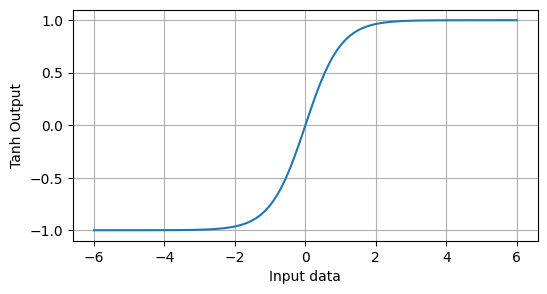

In [7]:
import matplotlib.pyplot as plt # Library for visualization
tanh = nn.Tanh()
assert not hasattr(tanh, "weight") # No learnable weights

data = torch.linspace(start=-6, end=6, steps=100) # One-dimensional vector with 100 elements 
output = tanh(data)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(data, output)
ax.set_xlabel("Input data")
ax.set_ylabel("Tanh Output")
ax.grid(True)

Et viktig poeng er at aktiveringsfunksjoner ikke modifiserer _shapen_ til tensoren. Dette kan demonstreres på en tensor med flere shape-dimensjoner. 

In [8]:
data = torch.rand(30, 5, 15)
print(f"shape before activation function: {data.shape}")
modified_data = tanh(data)
print(f"shape after activation function: {data.shape}")
print(f"But the content has changed: {not torch.isclose(data, modified_data).all()}")

shape before activation function: torch.Size([30, 5, 15])
shape after activation function: torch.Size([30, 5, 15])
But the content has changed: True


En annen viktig er `nn.Softmax`, og brukes til å transformere en vektor til elementer som summeres til 1. 

Dette gjør den litt annerledes enn Tanh, siden vi må spesifisere en av shape-dimensjonene som skal summeres til 1.

Den gjør seg svært godt som siste lag i et nettverk vi ønsker skal modellere en sannsynlighetsfordeling (Total sannsynlighet av alle utfallene av en stokastisk variabel skal være 1). Den er feks brukt som siste lag i ChatGPT, siden språkmodeller lærer seg en betinget sannsynlighetsfordeling over ord gitt tidligere tekst. 

For denne anledningen tar vi også i bruk `nn.functional`, som er et delbibliotek som tilbyr mange av komponentene tilstandsfrie. 

In [9]:
import torch.nn.functional as F

# data = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
data = torch.randn(3, 2)
print(f"Original data:\n{data}")
data = F.softmax(data, dim=1)
print(f"Transformed data:\n{data}")
print(f"Summing individual batch elements:\n{data.sum(dim=1)}")

Original data:
tensor([[-0.8821,  0.4546],
        [ 1.7497,  1.4658],
        [-0.6145,  0.7334]])
Transformed data:
tensor([[0.2081, 0.7919],
        [0.5705, 0.4295],
        [0.2062, 0.7938]])
Summing individual batch elements:
tensor([1., 1., 1.])


## Klassifisering av sifre
Vi skal sette opp et nevralt nettverk som er i stand til å klassifisere sifre. Til det trenger vi det lett tilgjengelige MNIST-datasettet. Dette lastes ned gjennom torchvision-biblioteket. Torchvision-biblioteket er et hjelpebibliotek som tilbyr verktøy for Computer Vision-oppgaver. 

Datasett kommer vanligvis i et rå-format, og må behandles for å tilpasse det oppgaven vi skal gjøre. I dette tilfellet får vi PNG-bilder som må gjøres om til tensorer. Vi normaliserer også bildene for å få [bedre resultater](https://developers.google.com/machine-learning/data-prep/transform/normalization). Behandlingen gjøres med `torchvision.transforms`-biblioteket. 

Datasettet lagres i roten av prosjektet i mappen `data`.

In [10]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into torch.Tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
])

train_dataset = MNIST(root='../data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='../data', train=False, transform=image_processing, download=True) # Test data for later

I maskinlæring trener man flere epoker (iterasjoner) på samme datasettet. 

Hver epoke inneholder igjen flere iterasjoner som består av å oppdatere vektene på et lite subset av datasettet. Man kaller dette for en batch. Denne logikken oppnår vi delvis gjennom `torch.utils.data.DataLoader`. Resten kommer når selve treningen skjer. 

In [11]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) # Iterable that provides 16 data samples each iteration

data, labels = next(iter(train_loader)) # Retrieve a batch of data samples and labels for inspection purposes
print(f"Shape of data batch: {data.shape}")


Shape of data batch: torch.Size([32, 1, 28, 28])


Tensoren inneholder 32 eksemplarer, 1 fargekanal (grayscale), 28 piksler i høyden, og 28 piksler i bredden.
Vi kan visualisere et tilfeldig eksemplar fra hele datasettet.

Shown below is the digit 5


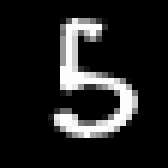

In [12]:
from utils.visualize import visualize

rand_index = torch.randint(0, len(train_dataset), (1,)).item()
data_sample, label_sample = train_dataset[rand_index]
print(f"Shown below is the digit {label_sample}")
visualize(data_sample)

Og tensoren i seg selv ser slik ut:

In [13]:
data_sample

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -0.9137, -0

### Vi trenger et nettverk
Alle lag i PyTorch arver fra `nn.Module`. Fra [dokumentasjonen](https://pytorch.org/docs/stable/generated/torch.nn.Module.html):

>Base class for all neural network modules. 
>
>Your models should also subclass this class.
>
>Modules can also contain other Modules, allowing to nest them in a tree structure.

Trestrukturen som nevnes er veldig nyttig. Endringer vi gjør på toppen av treet vil propageres ned til enkeltmodulene. Feks det å flytte parametrene over på en GPU.

Vi husker det enkle lineære laget og tanh-funksjonen. De arver nemlig fra `nn.Module`.

In [14]:
print(layer.__class__.__base__)
print(tanh.__class__.__base__)

<class 'torch.nn.modules.module.Module'>
<class 'torch.nn.modules.module.Module'>


Nettverket vi lager inneholder tre lag:
1. `layer1` tar inn et bilde med 28 $\times$ 28 piksler flatet ut til en vektor med 784 features. Denne transformeres til en vektor med et vilkårlig antall features. Vi velger 200.
2. `layer2` tar inn en vektor med 200 features og produserer en vektor med 42 features.
3. `layer3` tar inn en vektor med 42 features og produserer en vektor med samme antall features som antallet siffer vi ønsker å skille mellom.

Mellom hvert lag bruker vi `Tanh` som aktiveringsfunksjon.

Modellen vår implementerer to metoder. `logits` gir unnormaliserte verdier og vil brukes under trening. `forward` bruker `softmax` til å normalisere output fra `logits`, og tas i bruk under _inference_.

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1*28*28, out_features=200) # Input features are the number of pixels, output features is arbitrary
        self.layer2 = nn.Linear(in_features=200, out_features=42) # Arbitrary values
        self.layer3 = nn.Linear(in_features=42, out_features=10) # 10 digits to differentiate between

        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1) # Softmax will be computed for each batch element separately 

    def logits(self, data):
        # Flatten the tensor from shape (batch_size, 1, 28, 28) to shape (batch_size, 1 * 28 * 28)
        flattened_data = torch.flatten(data, start_dim=1, end_dim=-1) 

        out = self.layer1(flattened_data)
        out = self.tanh(out)

        out = self.layer2(out)
        out = self.tanh(out)

        out = self.layer3(out)
        return out
    
    def forward(self, data):
        logits = self.logits(data)
        return self.softmax(logits)
    
model = Model() # Initialize model
model.to(device) # Move model to GPU device

Model(
  (layer1): Linear(in_features=784, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=42, bias=True)
  (layer3): Linear(in_features=42, out_features=10, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [18]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 165872


Vi tester modellen på sifferet vi visualiserte tidligere.

In [17]:
print(data_sample.shape)
test_input = data_sample.unsqueeze(0) # add the batch dimension
print(test_input.shape)
test_input = test_input.to(device)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [18]:
out = model.forward(test_input)
print(out)
print(f"The untrained model predicts the digit to be {out.argmax()}")

tensor([[0.0760, 0.0972, 0.0970, 0.0967, 0.0846, 0.1462, 0.0960, 0.0964, 0.0964,
         0.1135]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The untrained model predicts the digit to be 5


## Trening
Vi ser fra resultatene at modellen ikke er i stand til å avgjøre hvilket siffer inputten var. 

Vi har modellen og datasettet. Da er det to viktige ting som mangler for å kunne oppnå en fungerende modell. 
- **En loss-funksjon som definerer objectivet**
    - Vi ønsker at modellen skal gi høyest sannsynlighet på det rette sifret.
    
- **En algoritme som utfører gradient descent, altså selve maskinlæringen**   
    - Denne algoritmen skal ta utgangspunkt i losset for å optimere parametrene.
    - Man implementerer slike aldri selv, og finner dem heller gjennom `torch.optim`.

### Loss-funksjoner
Loss-funksjoner sammenlikner en prediksjon mot en fasit, og gjør det mulig å måle hvor gode svarene er fra nettverket mot datasettet.  
Den enkleste er _Mean Squared Error (MSE)_, som kalkulerer gjennomsnittlig kvadrert avvik mellom tilsvarende elementer i hver tensor.


In [18]:
a = torch.ones(size=(3, 4, 5))
b = torch.zeros(size=(3, 4, 5))
loss = F.mse_loss(a, b)
print(loss)

a = torch.rand(size=(3, 4, 5))
b = torch.rand(size=(3, 4, 5))
loss = F.mse_loss(a, b)
print(loss)

tensor(1.)
tensor(0.1707)


### Gradient descent
Helt fram til beregningen av et loss konstrueres det en såkalt _computational graph_. Denne kan propageres bakover for å beregne gradienter (derav det kjente navnet [backpropagation](https://simple.wikipedia.org/wiki/Backpropagation) som brukes i alle nevrale nettverk idag).
- Fra matematikken vet vi at gradienter peker i retning hvor verdien øker mest i en flervariabel kurve. Beveger vi oss i motsatt retning vil verdien minske.
- Learning rate (en skalar verdi) styrer hvor store stegene er. 

Figuren under viser loss-funksjonen kalkulert for forskjellige verdier av parametrene $\theta_1$ og $\theta_2$ til en modell. 

[<img src="https://zitaoshen.rbind.io/project/optimization/1-min-of-machine-learning-gradient-decent/featured_hubf6ae7b9a0510d717632b017746fdfc1_374655_720x0_resize_lanczos_2.png">](https://zitaoshen.rbind.io/project/optimization/1-min-of-machine-learning-gradient-decent/)

Oppdatering av vektene gjøres da slikt:

$\boldsymbol{w} \leftarrow \underbrace{\alpha}_{\text{learning rate}}$

Selv om konkrete regler finnes for beregning av gradientene til vektene, er det svært kronglete å gjøre manuelt. Derfor takker vi AI-gudene for bibliotek som PyTorch og Tensorflow som gjør denne prosessen så og si automatisk. 

#### Tilbake til treningen av en siffer-gjenkjenneren
Til loss-funksjonen bruker vi `nn.CrossEntropyLoss`. Den sammenlikner to sannsynlighetsfordelinger. Matematikken bak er ikke så viktig.

Til gradient descent bruker vi bruker Adam, som står for _Adaptive Moment Estimation_. Her er heller ikke matematikken viktig.  
Vi spesifiserer en learning rate som forteller algoritmen hvor store endringer som gjøres på vektene ved hvert oppdateringssteg.

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
from tqdm import tqdm # Progress bar

num_epochs = 3

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, labels) in enumerate(pbar):
            data = data.to(device)
            labels = labels.to(device)
            pred = model.logits(data) # Query model for predictions
            loss = loss_fn(pred, labels)
            
            loss.backward() # Propagate the computational graph and calculate gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients

            # pbar.set_postfix(loss=loss.cpu().item()) if i%40 == 0 else None
    

Epoch 0:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 2: 100%|██████████| 1875/1875 [00:06<00:00, 288.18batch/s]


### Testing av modellen

In [22]:
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

correct = 0
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    pred = model.forward(data)
    correct += torch.sum(pred.argmax(dim=1) == labels)
accuracy = correct/len(test_dataset)

print(f"The accuracy of the model on the test set is {accuracy}")

The accuracy of the model on the test set is 0.9541999697685242


tensor([[4.0705e-05, 6.2762e-06, 5.1815e-05, 4.2608e-06, 1.6542e-04, 2.3789e-05,
         9.9967e-01, 1.4521e-06, 1.9247e-05, 1.4713e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
The trained model predicts the digit to be 6


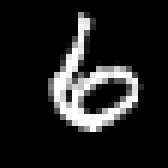

In [31]:
out = model.forward(test_input)
print(out)
print(f"The trained model predicts the digit to be {out.argmax()}")
visualize(test_input)